In [1]:
# run IPYNB that imports all the relevant packages and functions
%run ms_packages_and_functions.ipynb
import warnings
warnings.filterwarnings('ignore')

/home/mjms/anaconda3/envs/reach-analysis/lib/python3.8/site-packages/bids/layout/validation.py:46: UserWarning: The ability to pass arguments to BIDSLayout that control indexing is likely to be removed in future; possibly as early as PyBIDS 0.14. This includes the `config_filename`, `ignore`, `force_index`, and `index_metadata` arguments. The recommended usage pattern is to initialize a new BIDSLayoutIndexer with these arguments, and pass it to the BIDSLayout via the `indexer` argument.
  warnings.warn("The ability to pass arguments to BIDSLayout that control "


In [ ]:
output_dir = pjoin(os.getcwd(), 'processed_data')
data_dir  = pjoin(os.getcwd(), 'raw_data')

In [2]:
rockstar_data = pjoin(data_dir,'rockstar_CenterOut_data_10msBin_with500buffer.pkl')
with open(rockstar_data, 'rb') as f:
    data = pickle.load(f)

# 0. Data Structure

HOW TO USE 'data'

#data is already organized by direction:
```python
data[direction].keys()
## ['DirectionIndex', 'DirectionDegrees', 'numTrials', 'instructionTimes', 
## 'goTimes', 'startMv', 'endMv', 'numCh', 'binwin', 'StartTimes', 'trialData'])
```

within the 'direction' dictionary, all trial data is stored in 'trialData'
```python
data[direction]['trialData'][trial].keys()
## ['trialNum', 'trialStart', 'trialInstruction', 'trialGo', 'trialEnd', 
## 'trialXPos', 'trialXTime', 'trialYPos', 'trialYTime', 'unitData', 
## 'trialNumUnits', 'trialSpiketimes', 'trialBinnedSpikes']
```
and within each trial we have 'unitData' which has metadata about the units
```python
data[0]['trialData'][0]['unitData'][0].keys()
## ['chanNum', 'unitInChan', 'unitNum', 'spiketimes']
```

In [5]:
data[0]['trialData'][0]['unitData'][0].keys()

dict_keys(['chanNum', 'unitInChan', 'unitNum', 'spiketimes'])

In [12]:
data[0]['trialData'][0]['trialNumUnits']

141

# 1. Plot Data Raster by Trial

(-0.5, 300.5, 141.5, -0.5)

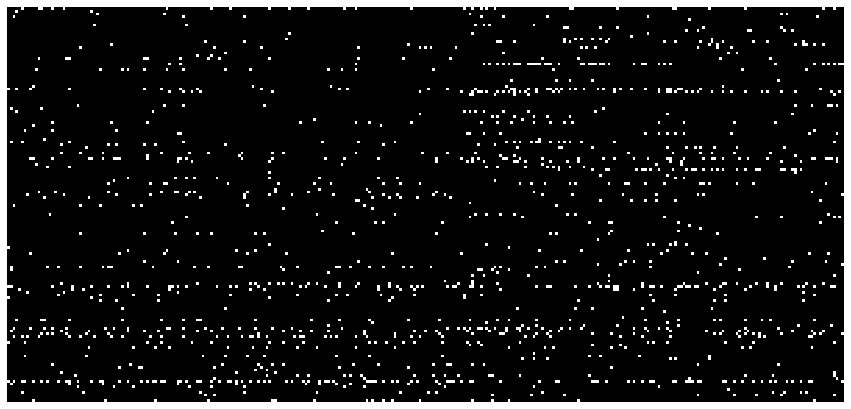

In [6]:
data_rasters = []
mov_window = 0.2 # 200 ms
buffer = 0.5

direction = 0
trial = 0

plt.figure(figsize=(15,30))
plt.imshow(data[direction]['trialData'][trial]['trialBinnedSpikes'],cmap='gray' )
plt.axis('off')

# 2. Get Firing Rates

In [7]:
data_rasters = []
mov_window = 0.2 # 200 ms
buffer = 0.5

for direction in range(0,len(data)):
    binwin = data[direction]['binwin']
    windowBin = int(mov_window/binwin)

    direction_rasters = []

    for trial in range(0,len(data[direction]['trialData'])):
        trial_rasters  = []
        trialData = data[direction]['trialData'][trial]['trialBinnedSpikes'] 

        for j in range(0,trialData[0].shape[0]-windowBin):
            temp = [x[j:j+windowBin] for x in trialData]

            trial_rasters.append(temp)

        direction_rasters.append(trial_rasters)

    data_rasters.append(direction_rasters)

In [68]:
len(raster_plot[0])

80

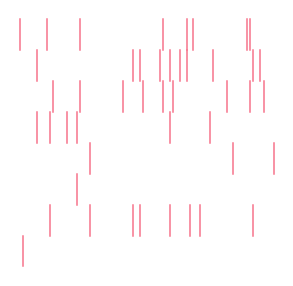

In [70]:
plt.figure(figsize=(5,5))
raster_plot = np.hstack((np.array(data_rasters[0][0][220][110:120]),np.array(data_rasters[0][0][240][110:120]),np.array(data_rasters[0][0][260][110:120]),np.array(data_rasters[0][0][280][110:120])))
scale = 1
for i,raster in enumerate(raster_plot):
    for j,val in enumerate(raster):
        if val:
            plt.plot([j,j],[i*scale,i*scale+scale],c=sns.color_palette('husl',1)[0])

ax1 = plt.gca()
# bg_color = '#F5F5F5'
# ax1.set_facecolor(bg_color)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)           
ax1.set_xticks([])
ax1.set_yticks([])

plt.savefig('example_raster.png',transparent=True)

In [8]:
rasters = [data_rasters]

FR_all = []
for i, raster in enumerate(rasters):
    FR_all.append([])
    
    for direction in range(0,len(raster)):
        direction_FR = []
        for trial in range(0,len(raster[direction])):
            trial_FR = []
            for time in range(0,len(raster[direction][trial])):
                trial_FR.append(np.sum(raster[direction][trial][time],axis=1))
            direction_FR.append(trial_FR)
        FR_all[i].append(direction_FR)

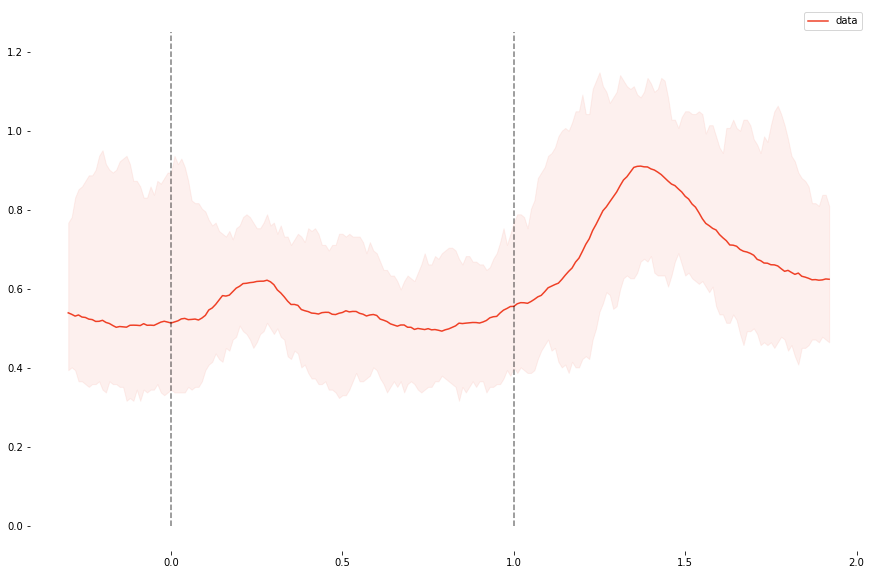

In [9]:
plt.figure(figsize=(15,10),frameon=False)

direction = 0
file = 0 

labels = ['data','poisson','shuffled']
c = ['xkcd:tomato','xkcd:teal','xkcd:turquoise']
plot_until = np.min([len(y) for z in FR_all for y in z[direction]])
time = (np.arange(0,plot_until)*0.01)-(0.5-0.2)

ave_FR = []
for trial in range(0,len(FR_all[file][direction])):
     ave_FR.append([np.mean(x) for x in FR_all[file][direction][trial]][:plot_until])

ave_FR_dir = np.mean(np.array(ave_FR),axis=0)
min_FR = np.min(np.array(ave_FR),axis=0)
max_FR = np.max(np.array(ave_FR),axis=0)

plt.fill_between(time, min_FR,max_FR,alpha=0.075,color=c[file])
plt.plot(time,ave_FR_dir,label=labels[file],color=c[file])

plt.plot([0,0],[0,1.25],'k--',alpha=0.5)
plt.plot([1,1],[0,1.25],'k--',alpha=0.5)
plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

# 3. Kinematics

In [ ]:
data_pos = []
mov_window = 0.2 # 200 ms
cmap = sns.color_palette('husl',8)
plt.figure(figsize=(10,10))
for direction in range(0,len(data)):
    for trial in range(0,len(data[direction]['trialData'])):
        xPos = data[direction]['trialData'][trial]['trialXPos']
        xTime = data[direction]['trialData'][trial]['trialXTime']

        yPos = data[direction]['trialData'][trial]['trialYPos']
        yTime = data[direction]['trialData'][trial]['trialYTime']
        
        plt.plot(xPos,yPos,color=cmap[direction])
plt.axis('off')
plt.show()

### Interpolated kinematics to match binning of spikes

In [ ]:
data_pos = []
mov_window = 0.2 # 200 ms
cmap = sns.color_palette('husl',8)
plt.figure(figsize=(10,10))
for direction in range(0,len(data)):
    for trial in range(0,len(data[direction]['trialData'])):
        binwin = data[direction]['binwin']
        xPos = data[direction]['trialData'][trial]['trialXPos']
        xTime = data[direction]['trialData'][trial]['trialXTime']

        yPos = data[direction]['trialData'][trial]['trialYPos']
        yTime = data[direction]['trialData'][trial]['trialYTime']
        
        xnew,ynew = binnedPos(xPos,xTime,yPos,yTime,binwin)
        plt.plot(xnew,ynew,color=cmap[direction])
plt.axis('off')
plt.show()

# 4. Construct FNs

In [ ]:
data_FNs = []
mov_window = 0.2 # 200 ms
mov_10ms = int(0.01/binwin) # move the mov_window this many bins
for direction in range(0,len(data)):
    binwin = data[direction]['binwin']
    windowBin = int(mov_window/binwin)
    
    direction_FNs = []
    
    for trial in range(0,len(data[direction]['trialData'])):
        trial_FNs  = []
        trialData = data[direction]['trialData'][trial]['trialBinnedSpikes'] 
        
        for j in range(0,trialData[0].shape[0]-windowBin,mov_10ms):
            status("computing FN for direction: {},trial: {}, window: {}/{}".format(direction, trial,j/mov_10ms,(trialData[0].shape[0]-windowBin-1)/mov_10ms))
            temp = [x[j:j+windowBin] for x in trialData]
            tempFN = make_FN(temp,metric='fMI',plot=False)
            trial_FNs.append(tempFN)
            
        direction_FNs.append(trial_FNs)
        
    data_FNs.append(direction_FNs)
    
# save as pkl file
save_dir = pjoin(output_dir,'CenterOut_FN_{}msBin_with{}buffer_MIonly.pkl'.format(int(binwin*1000),int(buffer*1000)))
savePickle(save_dir,data_FNs)
status("DONE!")